In [ ]:
!pip install shutup
##At the top of the code
import shutup
shutup.please()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#**<font color="orange">Import packages</font>**

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import numpy as np
import cv2
import os
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy, pickle, os, time
from google.colab import drive
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import glob
import seaborn as sn
import matplotlib.image as mpimg
%matplotlib inline
from skimage.io import imread
import PIL
from torchsummary import summary

#**<font color="orange">Download dataset</font>**

In [ ]:
!wget https://www.dropbox.com/s/9w8nmj791c9ogsx/data_upload_v3.zip

--2023-01-26 11:34:33--  https://www.dropbox.com/s/9w8nmj791c9ogsx/data_upload_v3.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9w8nmj791c9ogsx/data_upload_v3.zip [following]
--2023-01-26 11:34:34--  https://www.dropbox.com/s/raw/9w8nmj791c9ogsx/data_upload_v3.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc14765fb619304032fe47d2ad8c.dl.dropboxusercontent.com/cd/0/inline/B1TgVM8Jcy63HEV3r7n6Ro8mJh4dvp1JcyLHIHmBHf-JKXLDpJeSbHvjI7KIz0tBwkaAn2hwOrZ91CTHrHfvHscnbbSywIzlpBZRmgRdDKzR2QZexUF1aaaIqSyh1vwa5SVbM-jpRvuUShzTBH8DVURCn9X_MdLjbE8bolPK1SX7Jg/file# [following]
--2023-01-26 11:34:34--  https://uc14765fb619304032fe47d2ad8c.dl.dropboxusercontent.com/cd/0/inline/B1TgVM8Jcy63HEV3r7n6Ro8mJh4dvp1JcyLHIHmBHf-JKXLDpJeSbHvjI7KIz0

In [ ]:
!unzip -q data_upload_v3.zip

In [ ]:
# Get the root path to dataset folder
dataset_path = "/content/data_upload_v3"

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) , 
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes  

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
EPOCHS = 10
BATCHSIZE = 32

#**<font color="orange">Data Augmentation</font>**

In [ ]:
augmentation1 = transforms.Compose([
                     transforms.Resize(224),
                     transforms.RandomResizedCrop(224),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                     transforms.RandomRotation(degrees=(-10, 10)),
                     transforms.RandomHorizontalFlip(),
                     transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))
                 ])

augmentation2 = transforms.Compose([
                     transforms.Resize(224),
                     transforms.RandomResizedCrop(224),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                     transforms.RandomRotation(degrees=(-30, 30)),
                     transforms.RandomHorizontalFlip()
                 ])
augmented_dataset1 = datasets.ImageFolder(os.path.join(dataset_path, 'train'), augmentation1)
augmented_dataset2 = datasets.ImageFolder(os.path.join(dataset_path, 'train'), augmentation2)
image_datasets['train'] = torch.utils.data.ConcatDataset([image_datasets['train'], augmented_dataset1, augmented_dataset2])

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= batch, shuffle=True, num_workers= 0) for x, batch in [('train', BATCHSIZE), ('test', 1)]}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

#**<font color="orange">Functions</font>**

In [ ]:
def train_model(model, criterion, optimizer, batch_size, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc= []
    valid_acc= []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('----------------------')

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_size
                cur_batch_ind +=1
                
                if phase=='train':
                    train_acc.append(cur_acc)
                else:
                    valid_acc.append(cur_acc)
                
            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc} \n\n')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch + 1
                best_model_wts = copy.deepcopy(model.state_dict())



    time_elapsed = time.time() - since
    print(f'Training complete in {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s')
    print(f'Best val acc= {best_acc} at Epoch: {best_epoch}')

    model.load_state_dict(best_model_wts)
    return model, train_acc, valid_acc

In [ ]:
def test_model(model, test_dataloader, threshold):
  covid_predictions = []
  not_covid_prediction = []
  total_predictions = []
  grand_truth = []

  for image, labels in test_dataloader :
    cur_img = image.cuda().reshape(1, 3, 224, 224)
    out = model(cur_img)
    cur_prob2 = torch.nn.Softmax()(out)
    if float(cur_prob2[0][0])> threshold:
      total_predictions.append(0)
      covid_predictions.append(0)
      grand_truth.append(labels)
    else:
      total_predictions.append(1)
      not_covid_prediction.append(1)
      grand_truth.append(labels)

  covid_probs = []
  not_covid_probs = []
  for image, labels in test_dataloader:
    cur_img = image.cuda().reshape(1, 3, 224, 224)
    out = model(cur_img)
    cur_prob = torch.nn.Softmax()(out)
    if labels == 0 :
        covid_probs.append(cur_prob.cpu().data.numpy()[0,0])
    if labels == 1 :
        not_covid_probs.append(cur_prob.cpu().data.numpy()[0,0])
  a = 0
  for i in range(len(test_dataloader)):
    if grand_truth[i] == 0 :
      if total_predictions[i] == 1:
        a = a + 1
  b = 0
  for i in range(len(test_dataloader)):
    if grand_truth[i] == 1 :
      if total_predictions[i] == 0:
        b = b + 1
    
  sensivity = (100 - a) / 100
  specificity =  (3000 - b) / 3000
  

  print('num of samples predicted not covid but is covid :' ,a)
  print('num of samples predicted covid but not covid:' , b)
  print('num of total cases that predicted as covid: ' , len(covid_predictions))
  print('num of total cases that predicted as non covid :' ,len(not_covid_prediction))
  print('Sensitivity is :',sensivity)
  print('Specificity is :', specificity)
  return covid_probs , not_covid_probs ,covid_predictions , not_covid_prediction

In [ ]:
def probabilties(covid_prob ,non_prob ):
  bins = np.linspace(0, 1, 25)
  plt.subplot(211)
  plt.hist(covid_prob, bins, color= 'blue', histtype = 'bar', label='Probabilities of COVID-19 Samples')
  plt.ylim([0,10])
  plt.legend(loc='upper center')
  plt.subplot(212)
  plt.hist(non_prob, bins, color= 'green', label='Probabilities of Non-COVID Samples')
  plt.legend(loc='upper center')
  plt.savefig('./scores_histogram.png')


#**<font color="orange">Define Model</font>**

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for i, child in enumerate(model_conv.children()):
    if i >= 7 :
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters())  

summary(model_conv, (3, 224, 224), batch_size=BATCHSIZE)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [ ]:
model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv, BATCHSIZE, EPOCHS)
model_conv.eval()
torch.save(model_conv, './covid_resnet18.pt')

Epoch 1/10
----------------------
train Loss: 0.16222236256853403 Acc: 0.95489443378119 


test Loss: 0.07899920159247666 Acc: 0.9693548387096774 


Epoch 2/10
----------------------
train Loss: 0.10814965849769703 Acc: 0.9632117722328855 


test Loss: 0.06029406537329006 Acc: 0.9751612903225807 


Epoch 3/10
----------------------
train Loss: 0.08908034455071674 Acc: 0.9705694177863083 


test Loss: 0.04679861300280707 Acc: 0.9812903225806452 


Epoch 4/10
----------------------
train Loss: 0.07944297412993126 Acc: 0.972168905950096 


test Loss: 0.05532539968312179 Acc: 0.9790322580645161 


Epoch 5/10
----------------------
train Loss: 0.06996641438680815 Acc: 0.9750479846449136 


test Loss: 0.043493106604381035 Acc: 0.983225806451613 


Epoch 6/10
----------------------
train Loss: 0.07035717120249914 Acc: 0.9768074216250799 


test Loss: 0.03791785920211118 Acc: 0.9867741935483871 


Epoch 7/10
----------------------
train Loss: 0.06655489650071716 Acc: 0.9760076775431862 


test

#**<font color="orange">Test Model With thereshold 0.1</font>**

In [ ]:
covid_probs , not_covid_probs ,covid_predictions , not_covid_prediction = test_model(model_conv, dataloaders['test'], 0.1)

num of samples predicted not covid but is covid : 14
num of samples predicted covid but not covid: 33
num of total cases that predicted as covid:  119
num of total cases that predicted as non covid : 2981
Sensitivity is : 0.86
Specificity is : 0.989


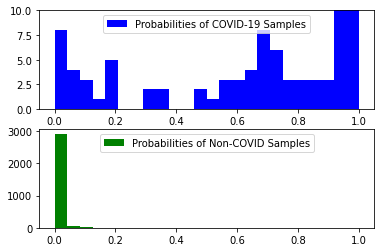

In [ ]:
probabilties(covid_probs , not_covid_probs)

#**<font color="orange">Test Model With thereshold 0.17</font>**

In [ ]:
covid_probs , not_covid_probs ,covid_predictions , not_covid_prediction = test_model(model_conv, dataloaders['test'], 0.17)

num of samples predicted not covid but is covid : 16
num of samples predicted covid but not covid: 13
num of total cases that predicted as covid:  97
num of total cases that predicted as non covid : 3003
Sensitivity is : 0.84
Specificity is : 0.9956666666666667


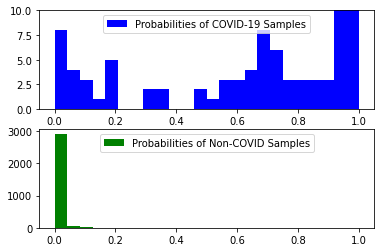

In [ ]:
probabilties(covid_probs , not_covid_probs)

#**<font color="orange">Test Model With thereshold 0.2</font>**

In [ ]:
covid_probs , not_covid_probs ,covid_predictions , not_covid_prediction = test_model(model_conv, dataloaders['test'], 0.2)

num of samples predicted not covid but is covid : 18
num of samples predicted covid but not covid: 10
num of total cases that predicted as covid:  92
num of total cases that predicted as non covid : 3008
Sensitivity is : 0.82
Specificity is : 0.9966666666666667


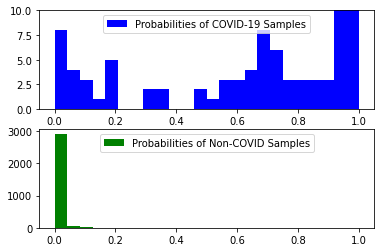

In [ ]:
probabilties(covid_probs , not_covid_probs)

#**<font color="orange">Test Model With thereshold 0.25</font>**

In [ ]:
covid_probs , not_covid_probs ,covid_predictions , not_covid_prediction = test_model(model_conv, dataloaders['test'], 0.25)

num of samples predicted not covid but is covid : 21
num of samples predicted covid but not covid: 9
num of total cases that predicted as covid:  88
num of total cases that predicted as non covid : 3012
Sensitivity is : 0.79
Specificity is : 0.997


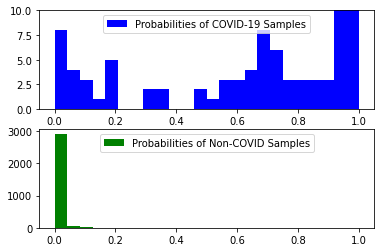

In [ ]:
probabilties(covid_probs , not_covid_probs)

#**<font color="orange">Test Model With thereshold 0.35</font>**

In [ ]:
covid_probs , not_covid_probs ,covid_predictions , not_covid_prediction = test_model(model_conv, dataloaders['test'], 0.35)

num of samples predicted not covid but is covid : 24
num of samples predicted covid but not covid: 3
num of total cases that predicted as covid:  79
num of total cases that predicted as non covid : 3021
Sensitivity is : 0.76
Specificity is : 0.999


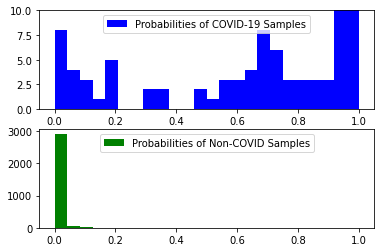

In [ ]:
probabilties(covid_probs , not_covid_probs)